In [1]:
import os 

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import umap

import torch
from scvi.dataset import CsvDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer

import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

import tempfile
import uuid

/usr/local/lib/python3.6/site-packages/numba/errors.py:102: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
!ls -lhtr /Users/dganguli/src/cellbench-scvi-stuffnthings/data

total 476232
-rw-r--r--  1 dganguli  staff    10K Dec 17 15:49 CellBench_scedrop_qc_cols.csv.gz
-rw-r--r--  1 dganguli  staff   1.2M Dec 17 15:49 CellBench_scedrop_qc.csv.gz
-rw-r--r--  1 dganguli  staff    15K Dec 17 15:49 CellBench_sce4_qc_cols.csv.gz
-rw-r--r--  1 dganguli  staff   2.0M Dec 17 15:49 CellBench_sce4_qc.csv.gz
-rw-r--r--  1 dganguli  staff    40K Dec 17 15:49 CellBench_sce10x_qc_cols.csv.gz
-rw-r--r--  1 dganguli  staff   6.8M Dec 17 15:49 CellBench_sce10x_qc.csv.gz
-rw-r--r--  1 dganguli  staff   1.5M Dec 18 14:09 scvi-stuffnthings.pkl
-rw-r--r--  1 dganguli  staff    25M Dec 19 13:33 a7e32c66-03d5-11e9-8c78-784f43989b25.csv
-rw-r--r--  1 dganguli  staff    25M Dec 19 13:34 d3fb2e70-03d5-11e9-a980-784f43989b25.csv
-rw-r--r--  1 dganguli  staff    25M Dec 19 13:35 e9bbb84c-03d5-11e9-a0c4-784f43989b25.csv
-rw-r--r--  1 dganguli  staff    25M Dec 19 13:35 046dc900-03d6-11e9-8b07-784f43989b25.csv
-rw-r--r--  1 dganguli  staff    25M Dec 19 13:37 436b2e2c-03d6-11e9-8c96-78

## Helper functions

In [7]:
base_path = '/Users/dganguli/src/cellbench-scvi-stuffnthings/data/'

# loads a gene by cell expression matrix, anc a cell level annotation dataframe
def load_data(file_name, base_path=base_path):

    # data frame
    df = pd.read_csv(os.path.join(base_path, file_name))
    df.rename(columns = {"Unnamed: 0": "gene"}, inplace=True)

    # cell annotations
    cols_file_name = file_name.split('.csv')[0]+'_cols.csv.gz'
    cols = pd.read_csv(os.path.join(base_path, cols_file_name))
    
    return df, cols

def load_scvi_data_from_file(file_name, base_path=base_path, num_genes=False):
    scvi_data = CsvDataset(file_name, save_path=base_path, compression="gzip", new_n_genes=num_genes)
    return scvi_data

def load_scvi_data_from_dataframe(df, base_path=base_path, num_genes=False):
    uuid_str = str(uuid.uuid1())+'.csv'
    tmp_path = os.path.join(base_path, uuid_str)
    df.to_csv(tmp_path, index=False)
    scvi_data = CsvDataset(uuid_str, save_path=base_path, new_n_genes=num_genes)
    return scvi_data
    
def get_common_genes(data_set_1, data_set_2):
    genes_1 = set(data_set_1.gene.values)
    genes_2 = set(data_set_2.gene.values)
    com_genes = genes_1.intersection(genes_2)
    print("data set 1 has: {} genes".format(len(genes_1)))
    print("data set 2 has: {} genes".format(len(genes_2)))
    print("number of common genes: {}".format(len(com_genes)))
    return com_genes

def umap_latent(z):
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(z)
    embedding.shape
    plt.scatter(embedding[:,0], embedding[:,1])
    return embedding

In [8]:
tenx, tenx_cols = load_data('CellBench_sce10x_qc.csv.gz')
drop, drop_cols = load_data('CellBench_scedrop_qc.csv.gz')

In [9]:
com_genes = get_common_genes(tenx, drop)

data set 1 has: 16468 genes
data set 2 has: 15127 genes
number of common genes: 13582


In [10]:
drop_sub_ind = drop.gene.isin(com_genes)
drop_sub = drop[drop_sub_ind].sort_values('gene')

tenx_sub_ind = tenx.gene.isin(com_genes)
tenx_sub = tenx[tenx_sub_ind].sort_values('gene')

len(drop_sub), len(tenx_sub)

(13582, 13582)

In [11]:
drop_sub.head()

,gene,CELL_000001,CELL_000002,CELL_000003,CELL_000004,CELL_000005,CELL_000006,CELL_000007,CELL_000008,CELL_000009,...,CELL_000228,CELL_000229,CELL_000230,CELL_000231,CELL_000233,CELL_000237,CELL_000238,CELL_000246,CELL_000249,CELL_000302
4235,ENSG00000000003,1,7,6,4,1,5,9,8,3,...,0,0,0,2,0,0,2,0,1,1
12734,ENSG00000000419,12,1,20,11,10,8,9,3,10,...,0,2,0,3,1,0,0,3,4,0
14611,ENSG00000000457,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7194,ENSG00000000460,0,2,3,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
1678,ENSG00000000971,0,0,0,1,0,0,0,9,0,...,0,0,0,0,0,0,2,0,2,0


In [12]:
tenx_sub.head()

,gene,CELL_000001,CELL_000002,CELL_000003,CELL_000004,CELL_000005,CELL_000006,CELL_000007,CELL_000008,CELL_000009,...,CELL_000931,CELL_000932,CELL_000933,CELL_000934,CELL_000935,CELL_000939,CELL_000943,CELL_000946,CELL_000955,CELL_000965
4631,ENSG00000000003,6,11,13,5,11,4,8,6,13,...,1,2,1,0,4,0,5,3,1,3
12861,ENSG00000000419,45,44,23,23,36,26,31,25,27,...,8,12,4,4,4,8,2,2,5,12
14037,ENSG00000000457,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
12454,ENSG00000000460,3,2,2,1,2,2,2,2,1,...,1,0,0,0,1,2,1,0,0,1
11547,ENSG00000000971,1,0,0,0,0,4,0,0,0,...,0,0,0,4,0,1,0,1,0,0


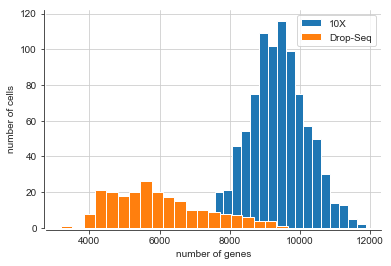

In [13]:
sns.set_style('ticks')
tenx_cols.number_of_genes.hist(bins=20)
sns.despine(offset=2)

drop_cols.number_of_genes.hist(bins=20)
sns.despine(offset=2)
plt.ylabel('number of cells')
plt.xlabel('number of genes')

plt.legend(['10X', 'Drop-Seq'])

## Naiive UMAP of concatenated data

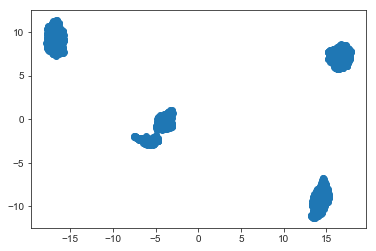

In [23]:
x = tenx_sub.loc[:, tenx_sub.columns != 'gene'].values
y = drop_sub.loc[:, drop_sub.columns != 'gene'].values
xy = np.concatenate([x, y], axis=1).T

emb = umap_latent(xy)

res = pd.DataFrame(emb)
res = res.rename(columns = {0:'x', 1:'y'})
cell_line = list(tenx_cols.cell_line.values) + list(drop_cols.cell_line.values) 
res['cell_line'] = cell_line
res['tech'] = '10X'
res.loc[0:902, 'tech'] = '10X'
res.loc[902:, 'tech'] = 'DropSeq'

res.to_csv('/Users/dganguli/Desktop/cell_bench_no_scvi.csv')

## Train model

### parameters

In [32]:
n_epochs_all = None
save_path = 'data/'
n_epochs=0 if n_epochs_all is None else n_epochs_all
lr=1e-3
use_batches=False
use_cuda=False

In [33]:
tenx_sub_scvi = load_scvi_data_from_dataframe(tenx_sub)
drop_sub_scvi = load_scvi_data_from_dataframe(drop_sub)

SystemError: <built-in method item of numpy.ndarray object at 0x128f5f850> returned a result with an error set

### train model

In [34]:
vae = VAE(tenx_sub_scvi.nb_genes, n_batch=tenx_sub_scvi.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              tenx_sub_scvi,
                              train_size=0.75,
                              use_cuda=False,
                              frequency=5)

trainer.train(n_epochs=n_epochs, lr=lr)

training: 0it [00:00, ?it/s]


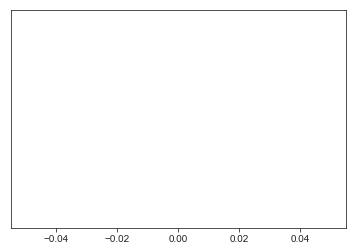

In [35]:
ll_train_set = trainer.history["ll_train_set"]
ll_test_set = trainer.history["ll_test_set"]
x = np.linspace(0,500,(len(ll_train_set)))
plt.plot(x, ll_train_set)
plt.plot(x, ll_test_set)
plt.yscale('log')

### save model

In [20]:
model_name = 'scvi-stuffnthings.pkl'
final_state = vae.state_dict()
torch.save(final_state, os.path.join(base_path, model_name))

### load model

In [21]:
vae_loaded = VAE(scvi_data.nb_genes, n_batch=scvi_data.n_batches * use_batches)
vae_loaded.load_state_dict(torch.load(os.path.join(base_path, model_name)))

## visualize latent representations

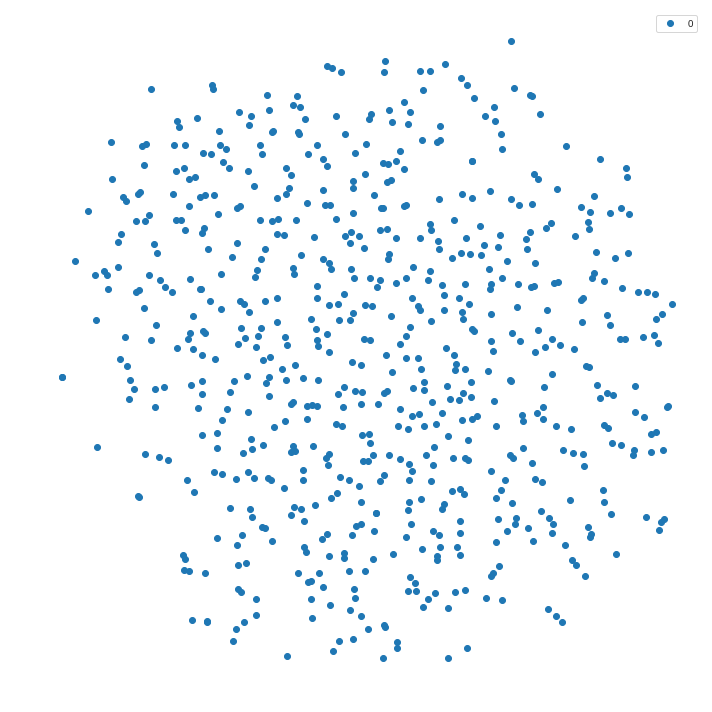

In [36]:
n_samples_tsne = 1000
trainer.train_set.show_t_sne(n_samples=n_samples_tsne, color_by='labels')

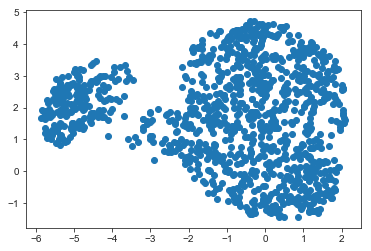

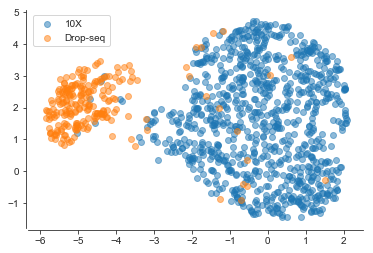

In [37]:
z = vae.sample_from_posterior_z(torch.tensor(tenx_sub_scvi.X), give_mean=True)
z = z.detach().numpy()

z_transfer = vae.sample_from_posterior_z(torch.tensor(drop_sub_scvi.X), give_mean=True)
z_transfer = z_transfer.detach().numpy()

z_tot = np.concatenate([z, z_transfer])

sns.set_style('ticks')
emb = umap_latent(z_tot)

a = emb[0:902, :]
b = emb[902:, :]

plt.figure()
plt.scatter(a[:,0], a[:,1], alpha=0.5)
plt.scatter(b[:,0], b[:,1], alpha=0.5)
plt.legend(['10X', 'Drop-seq'])
sns.despine(offset=2)

In [33]:
z.shape, z_transfer.shape

((902, 10), (225, 10))

In [38]:
a.shape, b.shape

((902, 2), (225, 2))

In [52]:
len(cell_line)

1127

In [62]:
res = pd.DataFrame(emb)
res = res.rename(columns = {0:'x', 1:'y'})
cell_line = list(tenx_cols.cell_line.values) + list(drop_cols.cell_line.values) 
res['cell_line'] = cell_line
res['tech'] = '10X'
res.loc[0:902, 'tech'] = '10X'
res.loc[902:, 'tech'] = 'DropSeq'

res.to_csv('/Users/dganguli/Desktop/cell_bench.csv')

In [98]:
zdf = pd.DataFrame(z_tot)
zdf = zdf.add_prefix('Activation')
zdf['cell_line'] = cell_line
zdf['tech'] = res.tech
longzdf = pd.wide_to_long(zdf.reset_index(), 'Activation', i="index", j="LV")
longzdf = longzdf.reset_index(level=0).reset_index(level=0)
del longzdf['index']
longzdf.to_csv('/Users/dganguli/Desktop/cell_bench_embedding.csv', index=0)

In [24]:
res = pd.DataFrame(emb)
res = res.rename(columns = {0:'x', 1:'y'})
cell_line = list(tenx_cols.cell_line.values) + list(drop_cols.cell_line.values) 
res['cell_line'] = cell_line
res['tech'] = '10X'
res.loc[0:902, 'tech'] = '10X'
res.loc[902:, 'tech'] = 'DropSeq'

res.to_csv('/Users/dganguli/Desktop/cell_bench_no_scvi.csv')